# Move visualization
This notebook makes visualization of hand position and save to the file. So you can use it for prediction visualization. That can give you insights about models perfomance

## Libraries

In [2]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from matplotlib.animation import PillowWriter
from matplotlib import animation
from IPython import display
import wandb
from pathlib import Path

## Functions for visualization

In [3]:
json_path = 'big_global_data.json'
name_to_color = {'thumb': 'red',
                 'index': 'blue',
                 'middle': 'green',
                 'ring': 'orange',
                 'pinky': 'pink'}

# with open(json_path, 'r') as f:
#     json_dict = json.load(f)

def multiply_quant(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    return (r1 * r2).as_quat()
def apply_quat(q, v):
    return R.from_quat(q).apply(v)

def get_finger_vecs_custom(hand_data, finger_start_pose, name):
    e = np.array([1, 0, 0])
    
    
    quat1 = hand_dict['b_r_wrist']
    
    quat2 = hand_dict[f'b_r_{name}1']
    quat3 = hand_dict[f'b_r_{name}2']
    quat4  = hand_dict[f'b_r_{name}3']
    
    quat1_inv = R.from_quat(quat1).inv().as_quat()
    
    
    quats = [quat1, quat2, quat3, quat4]
    quats = [multiply_quant(quat1_inv, q) for q in quats]
    
    t_vecs = [apply_quat(q, e) for q in quats] 

    prev = np.array(finger_start_pose[name])
    
    prev = apply_quat(quat1_inv, prev)

    
    t_vecs = [v * np.linalg.norm(prev)/2 for v in t_vecs]

    
    # get sequential summation of the vectors.
    t_vecs_new =[]

    t_vecs_new.append(prev)
    for v in t_vecs[1:]:
        prev = prev + v
        t_vecs_new.append(prev)
    
    t_vecs_new = np.stack(t_vecs_new)
    return t_vecs_new
    
def inverse_rotations(sample):


    ### normalisation if needed.
    quat_base = sample[0]
    quat_base_inv = R.from_quat(quat_base).inv().as_quat()

    quats_new = [multiply_quant(quat_base_inv, q) for q in sample]
    quats_new = np.stack(quats_new)

    return quats_new


class Hand:
    """
    Allows to get slice of Hand parameters.
    
    """
    name_to_idx = {"b_r_wrist": 0, "b_r_index1": 1,
                   "b_r_index2": 2, "b_r_index3": 3,
                   "b_r_middle1": 4, "b_r_middle2": 5,
                   "b_r_middle3": 6, "b_r_pinky1": 7,
                   "b_r_pinky2" : 8, "b_r_pinky3": 9,
                   "b_r_ring1": 10, "b_r_ring2": 11,
                   "b_r_ring3": 12, "b_r_thumb1": 13,
                   "b_r_thumb2": 14, "b_r_thumb3": 15}

    idx_to_name = {0: "b_r_wrist", 1: "b_r_index1",
               2: "b_r_index2", 3: "b_r_index3",
               4: "b_r_middle1", 5: "b_r_middle2",
               6: "b_r_middle3", 7: "b_r_pinky1",
               8: "b_r_pinky2", 9: "b_r_pinky3",
               10: "b_r_ring1", 11: "b_r_ring2",
               12: "b_r_ring3", 13: "b_r_thumb1",
               14: "b_r_thumb2", 15: "b_r_thumb3"}
    
    
    # normalize start point of hand
    
    finger_start_pose = {'thumb': np.array([ 1.79773151e-04, -9.56848596e-05,  1.40103373e-04]),
                         'index': np.array([ 4.79965970e-04, -3.64983564e-05,  1.17722357e-04]),
                         'middle': np.array([ 4.78224132e-04, -1.26683160e-05,  8.61489718e-06]),
                         'ring': np.array([ 4.43463102e-04, -3.26179546e-05, -8.73337173e-05]),
                         'pinky': np.array([ 3.89465811e-04, -6.83795585e-05, -1.75300101e-04])}
    
    
    finger_names = ['thumb', 'index', 'middle', 'ring', 'pinky']
    name_to_color = {'thumb': 'red',
                 'index': 'blue',
                 'middle': 'green',
                 'ring': 'orange',
                 'pinky': 'pink'}
    # init method or constructor 
    def __init__(self, data, hand_type='right'):
        """
        
        data - [frames, n_bones, 4] rotations
        """
        self.hand_type = hand_type
        
        self.azim, self.elev = -270, -220
        self.data = data
        self.all_points  = [] # N, 5, 4, 3 
#         self.points = for
    
    def get_rotations(self, i):
        
        sample = self.data[i]
        
        
        ### normalisation if needed.
        quat_base = sample[self.name_to_idx['b_r_wrist']]
        quat_base_inv = R.from_quat(quat_base).inv().as_quat()
        
        quats_new = [multiply_quant(quat_base_inv, q) for q in sample]
        quats_new = np.stack(quats_new)
        
        return quats_new
        
    def get_frame_points(self, idx):
        points = []
        for name in self.finger_names:
            tmp = self.get_one_finger_points(idx, name)
            points.append(tmp)
        return points
        
    
    def get_one_finger_points(self,idx, name):
    
        sample = self.get_rotations(idx)
        
        quat1 = sample[self.name_to_idx['b_r_wrist']]
        quat2 = sample[self.name_to_idx[f'b_r_{name}1']]
        quat3 = sample[self.name_to_idx[f'b_r_{name}2']]
        quat4  = sample[self.name_to_idx[f'b_r_{name}3']]

        quats = [quat1, quat2, quat3, quat4]
        
        e = np.array([1, 0, 0])
        
        t_vecs = [apply_quat(q, e) for q in quats]
        prev = np.array(self.finger_start_pose[name])
        t_vecs = [v * np.linalg.norm(prev)/2 for v in t_vecs]

        # get sequential summation of the vectors.
        t_vecs_new =[]

        t_vecs_new.append(prev)
        for v in t_vecs[1:]:
            prev = prev + v
            t_vecs_new.append(prev)

        t_vecs_new = np.stack(t_vecs_new)
        return t_vecs_new
        
    def convert_all_frames_to_points(self):
        self.all_points = [self.get_frame_points(n) for n in range(len(self))]
    
     
#     def fast_animation(self):
              
    def __len__(self):
        return len(self.data)
    
    def init_3dplot(self):

        fig = plt.figure(figsize = (5, 5))
        ax = Axes3D(fig)
        ax.view_init(azim=self.azim, elev=self.elev)
        
        return fig, ax

    
    def visualize_one_frame(self, idx, fig=None):
        """
        Fig is not None for animation only.
        """

        animate = False if fig is None else True
        if animate:
            ax = fig.axes[0]
        else:
            fig, ax = self.init_3dplot()
        
        plt.axis('off')
        lim = 0.0008
        ax.set_xlim(-lim/4, 2*lim)
        ax.set_ylim(-lim/2,lim/2)
        ax.set_zlim(-lim/2,lim/2)
        
        
        points = self.get_frame_points(idx)
        
        ## wrist position
        ax.scatter(0, 0, 0, s = 100, c = 'black', marker = '*')
        
        for i, finger_points in enumerate(points):
            x, y, z = finger_points[:, 0], finger_points[:, 1], -finger_points[:, 2]
            
            ax.scatter(x, y, z, c = name_to_color[self.finger_names[i]], s = 150)
            ax.plot([0, *x], [0, *y], [0, *z], 
                    color =name_to_color[self.finger_names[i]], 
                    linewidth=4)

        
        if not animate:
            return fig
        
    
    
    def visualize_all_frames(self):
        fig, ax = self.init_3dplot()
        
        def animate(i):
            plt.cla()
            value_points = self.visualize_one_frame(i, fig) 
        
        anim = animation.FuncAnimation(fig, animate, interval=1, frames =len(self), repeat=True, )
        
        return anim
    
    
def save_animation(anim, path, fps =  30):    
    writergif = animation.PillowWriter(fps=fps) 
    anim.save(path, writer=writergif)
    plt.close()        

    
def save_animation_mp4(anim, path, fps):
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(path, writer = FFwriter)
        
def visualize_val_moves(model, val_exps_data, epoch, device, window_size = 512):
    old_fps = 200
    new_fps = 20
    step = old_fps//new_fps
    
    for n, raw_data in enumerate(val_exps_data):
        
        x, y = raw_data['data_myo'][:window_size], raw_data['data_vr'][:window_size]
        
        y_pred = model.inference(x, device)

        hand_gt = Hand(y[-256::step])
        hand_pred = Hand(y_pred[-256::step])
        
        gt_path = f'{wandb.run.dir}/videos/{n}_move/true_sample_{epoch}.gif'
        pred_path = f'{wandb.run.dir}/videos/{n}_move/pred_sample_{epoch}.gif'
        Path(gt_path).parent.mkdir(parents=True, exist_ok=True)

        plt.close()
        ani_gt = hand_gt.visualize_all_frames()
        save_animation(ani_gt, gt_path, fps = new_fps)
        
        plt.close()
        ani_pred = hand_pred.visualize_all_frames()
        save_animation(ani_pred, pred_path, fps = new_fps)

        
        wandb.log({f"visualization/{n}_move": [wandb.Video(gt_path, fps=new_fps), 
                                               wandb.Video(pred_path, fps=new_fps)]})
        del hand_gt
        del hand_pred

## Visualize data

Get one movements data and save as video. 

In [4]:
with np.load('/kaggle/input/pred-final/predict_lstm_final.npz', allow_pickle=True) as data:
    data_vr = np.array(data['arr_0'][0])
    data_vr_viz = []
    for i in range(len(data_vr)):
        data_vr_viz.append(np.array(data_vr[i]).reshape(16, 4))
    target_hand = Hand(data_vr_viz[::1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


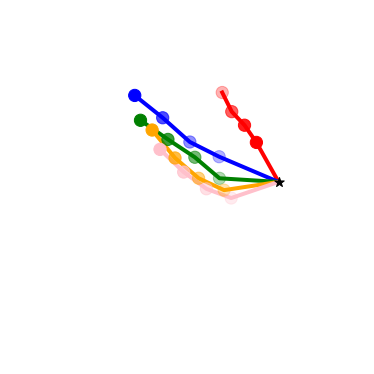

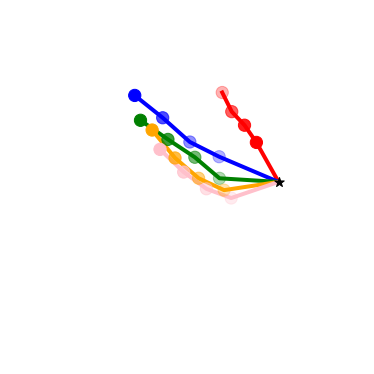

In [44]:
target_hand = Hand(data_vr_viz[::1])
target_hand.visualize_one_frame(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


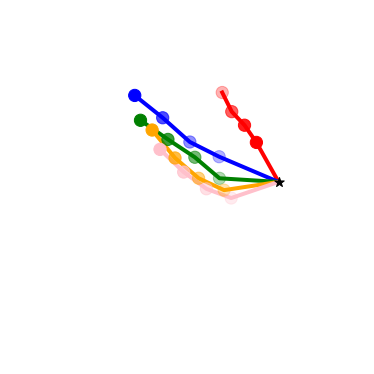

In [5]:
output_folder = Path(f"/kaggle/working/figures/")
output_folder.mkdir(parents=True, exist_ok=True)

prefix_name = f"one_moves_fps_{30}"

target_hand = Hand(data_vr_viz[::30])
target_hand_anim = target_hand.visualize_all_frames()
targets_path = output_folder / f"{prefix_name}.mp4"

save_animation_mp4(target_hand_anim, targets_path, fps=30)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


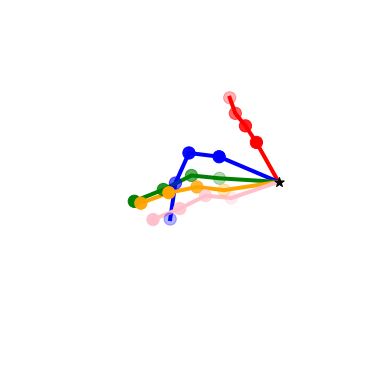

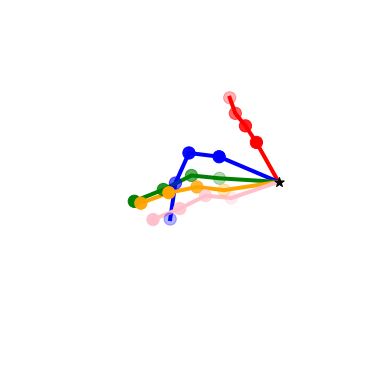

In [136]:
target_hand.visualize_one_frame(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


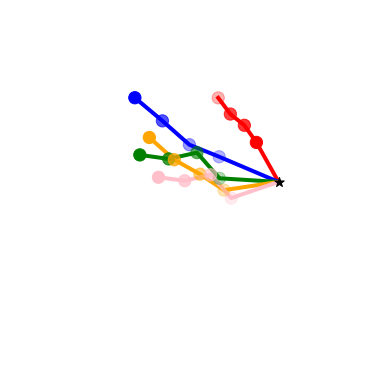

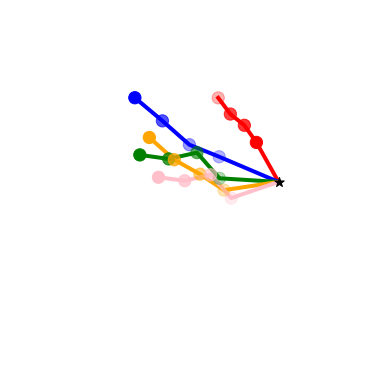

In [108]:
target_hand = Hand(data_vr_viz[::2])
target_hand.visualize_one_frame(0)